In [13]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import time

In [3]:
mx.set_default_device(mx.gpu)

mx.default_stream(mx.default_device())

Stream(Device(gpu, 0), 0)

In [5]:
def clamp(value: mx.array, min_value, max_value) -> mx.array:
    """
    Clamp a value to be within the range [min_value, max_value].

    Parameters:
    - value: The value to be clamped.
    - min_value: The minimum value of the range.
    - max_value: The maximum value of the range.

    Returns:
    The clamped value.
    """

    # return max(min_value, min(value, max_value))
    return mx.maximum(mx.minimum(value, max_value), min_value)
    # return mx.array([max(min_value, min(x, max_value)) for x in value])


In [6]:
class BitLinear(nn.Linear):
    """
    BitLinear is a custom linear layer that performs binarization of weights and quantization of activations
    in a group-wise manner.

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        bias (bool, optional): If set to False, the layer will not learn an additive bias. Default is True.
        num_groups (int, optional): Number of groups to divide the weights and activations into. Default is 1.
    """

    def __init__(self, input_dims: int, output_dims: int, bias: bool = True, num_groups: int = 1, b: int = 8):
        super().__init__(input_dims, output_dims, bias)

        self.input_dims = input_dims
        self.output_dims = output_dims
        self.num_groups = num_groups
        self.eps = 1e-5
        self.norm = nn.LayerNorm(input_dims)

        # Quantiziation and dequantization
        self.Q_b = 2 ** (b - 1)
        self.beta = mx.zeros((self.weight.shape[0],))
        self.gamma = mx.zeros((self.weight.shape[0],))

    def ste(self, x):
        """
        Applies the sign function for binarization and uses Straight-Through Estimator (STE) during backward pass.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Binarized tensor.
        """
        binarized_x = mx.sign(x)
        # Straight-THrough Estimator for backward pass
        # TODO: this is not differentiable so does not work for training!
        # The workaround in pytorch is below (use detach for Straight-Through Estimator during backprop)
        # binarized_x = (binarized_x - x).detach() + x
        return binarized_x

    def binarize_weights_groupwise(self):
        """
        Binarizes the weights of the layer in a group-wise manner using STE.

        Returns:
            Tensor: Binarized weights tensor.
        """
        group_size = self.weight.shape[0] // self.num_groups
        binarized_weights = mx.zeros_like(self.weight)

        for g in range(self.num_groups):
            start_idx = g * group_size
            end_idx = (g + 1) * group_size
            weight_group = self.weight[start_idx:end_idx]
            alpha_g = weight_group.mean()
            self.beta[start_idx:end_idx] = weight_group.abs().mean()
            binarized_weights[start_idx:end_idx] = self.ste(weight_group - alpha_g)

        return binarized_weights

    def quantize_activations_groupwise(self, x):
        """
        Quantizes the activations of the layer in a group-wise manner.

        Args:
            x (Tensor): Input tensor.
            b (int, optional): Number of bits for quantization. Default is 8.

        Returns:
            Tensor: Quantized activations tensor.
        """
        group_size = x.shape[0] // self.num_groups
        quantized_x = mx.zeros_like(x)

        for g in range(self.num_groups):
            start_idx = g * group_size
            end_idx = (g + 1) * group_size
            activation_group = x[start_idx:end_idx]

            gamma_g = activation_group.abs().max()
            self.gamma[start_idx:end_idx] = gamma_g
            quantized_x[start_idx:end_idx] = clamp(
                activation_group * self.Q_b / (gamma_g + self.eps),
                -self.Q_b + self.eps,
                self.Q_b - self.eps,
            )

        return quantized_x

    def dequantize_activations_groupwise(self, x):
        """
        Dequantizes the activations of the layer in a group-wise manner.

        Args:
            x (Tensor): Quantized input tensor.

        Returns:
            Tensor: Dequantized activations tensor.
        """

        return x * self.gamma * self.beta / self.Q_b


    def __call__(self, x: mx.array) -> mx.array:
        x = self.norm(x)

        # Binarize weights and quantize activations
        binarized_weights = self.binarize_weights_groupwise()

        # Quantize input
        x_quant = self.quantize_activations_groupwise(x)

        # Perform linear transformation
        # output = nn.functional.linear(x_quant, binarized_weights, self.bias)
        if "bias" in self:
            output = mx.addmm(self.bias, x_quant, binarized_weights.T)
        else:
            output = x_quant @ binarized_weights.T

        # Dequantize activations
        output = self.dequantize_activations_groupwise(output)

        # Return output
        return output

In [7]:
# benchmark BitLinear
iterations = 20

bl = BitLinear(512, 256, bias=False)

# prepare inputs
xs = [mx.random.uniform(shape=(512,)) for _ in range(iterations)]

start_time = time.time()
for i in range(iterations):
    x = xs[i]
    y = bl(x)
    print(y.sum())

end_time = time.time()
elapsed = end_time - start_time
print(f"elapsed: {elapsed}s")



array(-10.5409, dtype=float32)
array(0.134518, dtype=float32)
array(3.95243, dtype=float32)
array(-1.83306, dtype=float32)
array(0.124471, dtype=float32)
array(0.164674, dtype=float32)
array(8.27804, dtype=float32)
array(0.132467, dtype=float32)
array(8.34481, dtype=float32)
array(-12.4105, dtype=float32)
array(0.134869, dtype=float32)
array(19.5948, dtype=float32)
array(-12.8439, dtype=float32)
array(0.135861, dtype=float32)
array(1.10428, dtype=float32)
array(0.416769, dtype=float32)
array(0.128613, dtype=float32)
array(15.056, dtype=float32)
array(2.12251, dtype=float32)
array(0.128282, dtype=float32)
elapsed: 0.2404029369354248s


In [8]:
# benchmark QuantizedLinear
iterations = 20

ql = nn.QuantizedLinear(512, 256, bias=False)

# prepare inputs
xs = [mx.random.uniform(shape=(512,)) for _ in range(iterations)]

start_time = time.time()
for i in range(iterations):
    x = xs[i]
    y = ql(x)
    print(y.sum())

end_time = time.time()
elapsed = end_time - start_time
print(f"elapsed: {elapsed}s")



array(-5.52103, dtype=float32)
array(-9.48505, dtype=float32)
array(-1.79197, dtype=float32)
array(-4.27679, dtype=float32)
array(-8.3659, dtype=float32)
array(-6.67853, dtype=float32)
array(-2.10347, dtype=float32)
array(-7.04412, dtype=float32)
array(-5.36479, dtype=float32)
array(-11.6153, dtype=float32)
array(-6.95893, dtype=float32)
array(-4.62867, dtype=float32)
array(-10.2051, dtype=float32)
array(-5.60962, dtype=float32)
array(-6.69661, dtype=float32)
array(-4.80713, dtype=float32)
array(-8.36427, dtype=float32)
array(-6.04276, dtype=float32)
array(-2.55942, dtype=float32)
array(-4.79891, dtype=float32)
elapsed: 0.09306097030639648s


In [175]:

class BitBlock(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.layers = [
            BitLinear(input_dims, output_dims),
            nn.GELU()
        ]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
            # if "weight" in l:
            #     print(l.weight)

        return x

class BitModel(nn.Module):
    def __init__(self, num_layers, input_dims, output_dims, hidden_dims = 128):
        super().__init__()
        self.layers = [
            BitBlock(
                input_dims if i == 0 else hidden_dims, output_dims if i == num_layers-1 else hidden_dims
            )
            for i in range(num_layers)
        ]
        print(self.layers)

    def __call__(self, x):
        for l in self.layers:
            x = l(x)

        return x

class StandardBlock(nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.layers = [
            nn.Linear(input_dims, output_dims),
            nn.GELU()
        ]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
            # if "weight" in l:
            #     print(l.weight)

        return x

class StandardModel(nn.Module):
    def __init__(self, num_layers, input_dims, output_dims, hidden_dims = 128):
        super().__init__()
        self.layers = [
            StandardBlock(
                input_dims if i == 0 else hidden_dims, output_dims if i == num_layers-1 else hidden_dims
            )
            for i in range(num_layers)
        ]
        print(self.layers)

    def __call__(self, x):
        for l in self.layers:
            x = l(x)

        return x


# model = StandardModel(2, 1, 1)
model = BitModel(2, 1, 1)
# y = model(mx.array([2]))
# print(f"{y=}")

# y = bl(mx.random.uniform(shape=(512,)))
# print(y)

def loss_fn(model, inputs, targets):
    predictions = model(inputs)
    return nn.losses.mse_loss(predictions, targets)

optimizer = optim.AdamW(
    learning_rate=0.01
)


def step(inputs, targets):
    loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
    loss, grads = loss_and_grad_fn(model, inputs, targets)
    optimizer.update(model, grads)
    return loss


[BitBlock(
  (layers.0): BitLinear(input_dims=1, output_dims=128, bias=True
    (norm): LayerNorm(1, eps=1e-05, affine=True)
  )
  (layers.1): GELU()
), BitBlock(
  (layers.0): BitLinear(input_dims=128, output_dims=1, bias=True
    (norm): LayerNorm(128, eps=1e-05, affine=True)
  )
  (layers.1): GELU()
)]


In [174]:
state = [model.state, optimizer.state]

# points_to_predict = [(0, 0), (1, 1) , (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]
points_to_predict = [(1, 1) , (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]

def run_predictions():
    for (x, y) in points_to_predict:
        print(f"{x} -> (predicted: {model(mx.array([x]))}, actual: {y})")

run_predictions()

print(model.layers[0].layers[0].weight)

losses = []
for _ in range(100):
    loss = step(mx.array([mx.array([x]) for (x, y) in points_to_predict]), mx.array([mx.array([y]) for (x, y) in points_to_predict]))
    print(f"{loss.item()=}")
    losses.append(loss.item())
    mx.eval(state)

print(model.layers[0].layers[0].weight)


run_predictions()



1 -> (predicted: array([0.124555], dtype=float32), actual: 1)
2 -> (predicted: array([0.251041], dtype=float32), actual: 2)
3 -> (predicted: array([0.455641], dtype=float32), actual: 3)
4 -> (predicted: array([0.710445], dtype=float32), actual: 4)
5 -> (predicted: array([0.98194], dtype=float32), actual: 5)
6 -> (predicted: array([1.25097], dtype=float32), actual: 6)
7 -> (predicted: array([1.51102], dtype=float32), actual: 7)
array([[0.795808],
       [0.601737],
       [0.437837],
       ...,
       [0.165596],
       [0.113799],
       [-0.224132]], dtype=float32)
loss.item()=12.849590301513672
loss.item()=4.815029144287109
loss.item()=12.874555587768555
loss.item()=1.1870923042297363
loss.item()=3.695349931716919
loss.item()=7.815930366516113
loss.item()=2.6071527004241943
loss.item()=0.08770393580198288
loss.item()=2.9213662147521973
loss.item()=3.759636402130127
loss.item()=1.379397988319397
loss.item()=0.004104378633201122
loss.item()=0.8642010688781738
loss.item()=1.97760593891

[21.101459503173828, 0.47386592626571655, 26.333688735961914, 2.4701592922210693, 4.623295783996582, 14.156898498535156, 9.884688377380371, 2.377169609069824, 0.056356072425842285, 2.595970630645752, 4.557614803314209, 3.433642864227295, 1.223541498184204, 0.06760011613368988, 0.2686496675014496, 1.0627397298812866, 1.7084771394729614, 1.8636764287948608, 1.5341953039169312, 0.932183563709259, 0.34674862027168274, 0.026370542123913765, 0.0704040452837944, 0.3711633086204529, 0.6758856177330017, 0.7641623616218567, 0.5984841585159302, 0.31351780891418457, 0.08336191624403, 0.0035963859409093857, 0.06311246752738953, 0.18593630194664001, 0.2891294062137604, 0.321350634098053, 0.2748342454433441, 0.17782698571681976, 0.07632899284362793, 0.012276235967874527, 0.005111574660986662, 0.04424175247550011, 0.09705225378274918, 0.12889669835567474, 0.12270410358905792, 0.08563117682933807, 0.04025556519627571, 0.008839113637804985, 0.0016827760264277458, 0.014914898201823235, 0.0359645858407020

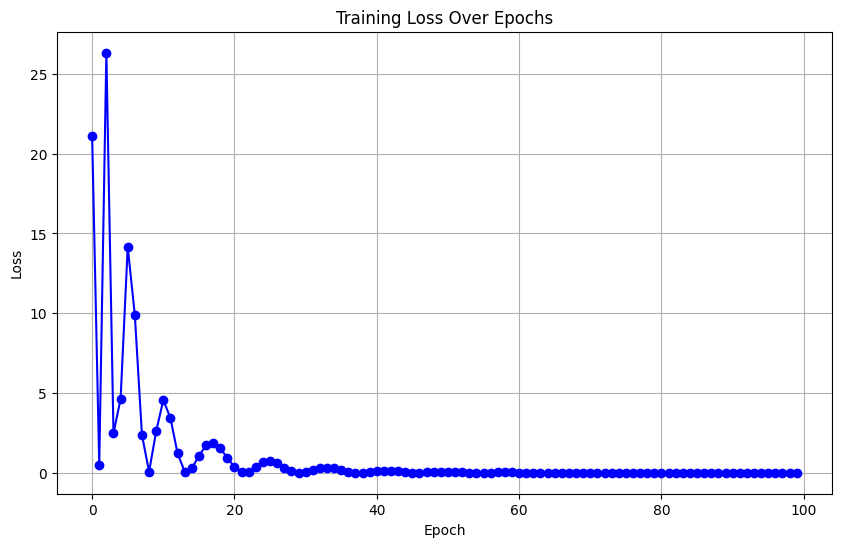

In [160]:
import matplotlib.pyplot as plt


print(losses[0:100])
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()